# Fostasting Moving Average using ARIMA model

## Data Cleaning
---
Before we start to build the ARIMA model and forecast the moving average, we need to wrangle our data and make it suitable for our purposes.

In [1]:
# load modules
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 999)

In [2]:
# load data and convert date to datetime
fw = pd.read_csv('..//Datasets/NEW/FW_with_airports.csv', parse_dates=['date'])

fw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23160 entries, 0 to 23159
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   tail_number               23160 non-null  object        
 1   date                      23160 non-null  datetime64[ns]
 2   aircraft                  22966 non-null  object        
 3   origin                    23160 non-null  object        
 4   origin_location           23160 non-null  object        
 5   destination               23159 non-null  object        
 6   destination_location      23159 non-null  object        
 7   departure                 23160 non-null  object        
 8   arrival                   22734 non-null  object        
 9   duration                  22711 non-null  object        
 10  distance_mi               22396 non-null  float64       
 11  Owner                     23160 non-null  object        
 12  origin_Latitude   

In [3]:
fw.head()

,tail_number,date,aircraft,origin,origin_location,destination,destination_location,departure,arrival,duration,distance_mi,Owner,origin_Latitude,origin_Longitude,destination_Latitude,destination_Longitude,ICAO_code_origin,iata_code_origin,AIRPORT_NAME_origin,CITY_NAME_origin,COUNTRY_NAME_origin,STATE_NAME_origin,origin_state,ICAO_code_destination,iata_code_destination,AIRPORT_NAME_destination,CITY_NAME_destination,COUNTRY_NAME_destination,STATE_NAME_destination,destination_state
0,N100KB,2021-02-20,BE9L,Williston Basin International Airport (KXWA),Williston Basin International Airport (Willist...,Bismarck Municipal (KBIS),"Bismarck Municipal (Bismarck, ND) - KBIS",04:57PM CST,05:44PM CST,0:46,174.190333,"EXECUTIVE AIR TAXI CORPBISMARCK, ND, US(Corpor...",48.260833,-103.751111,46.772701,-100.746002,KXWA,XWA,Williston Basin International,Williston - ND,United States,North Dakota,ND,KBIS,BIS,Bismarck Municipal,Bismarck - ND,United States,North Dakota,ND
1,N100KB,2021-02-20,BE9L,Bismarck Municipal (KBIS),"Bismarck Municipal (Bismarck, ND) - KBIS",Williston Basin International Airport (KXWA),Williston Basin International Airport (Willist...,01:36PM CST,02:27PM CST,0:51,174.190333,"EXECUTIVE AIR TAXI CORPBISMARCK, ND, US(Corpor...",46.772701,-100.746002,48.260833,-103.751111,KBIS,BIS,Bismarck Municipal,Bismarck - ND,United States,North Dakota,ND,KXWA,XWA,Williston Basin International,Williston - ND,United States,North Dakota,ND
2,N100KB,2021-02-18,BE9L,Minot International (KMOT),"Minot International (Minot, ND) - KMOT",Bismarck Municipal (KBIS),"Bismarck Municipal (Bismarck, ND) - KBIS",08:20AM CST,08:53AM CST,0:32,105.704153,"EXECUTIVE AIR TAXI CORPBISMARCK, ND, US(Corpor...",48.259399,-101.279999,46.772701,-100.746002,KMOT,MOT,Minot International,Minot - ND,United States,North Dakota,ND,KBIS,BIS,Bismarck Municipal,Bismarck - ND,United States,North Dakota,ND
3,N100KB,2021-02-15,BE9L,Williston Basin International Airport (KXWA),Williston Basin International Airport (Willist...,Minot International (KMOT),"Minot International (Minot, ND) - KMOT",02:15PM CST,02:49PM CST,0:33,114.003515,"EXECUTIVE AIR TAXI CORPBISMARCK, ND, US(Corpor...",48.260833,-103.751111,48.259399,-101.279999,KXWA,XWA,Williston Basin International,Williston - ND,United States,North Dakota,ND,KMOT,MOT,Minot International,Minot - ND,United States,North Dakota,ND
4,N100KB,2021-02-15,BE9L,Minot International (KMOT),"Minot International (Minot, ND) - KMOT",Williston Basin International Airport (KXWA),Williston Basin International Airport (Willist...,08:00AM CST,08:32AM CST,0:32,114.003515,"EXECUTIVE AIR TAXI CORPBISMARCK, ND, US(Corpor...",48.259399,-101.279999,48.260833,-103.751111,KMOT,MOT,Minot International,Minot - ND,United States,North Dakota,ND,KXWA,XWA,Williston Basin International,Williston - ND,United States,North Dakota,ND


In [4]:
# Check for null values
fw.isna().sum()

tail_number                    0
date                           0
aircraft                     194
origin                         0
origin_location                0
destination                    1
destination_location           1
departure                      0
arrival                      426
duration                     449
distance_mi                  764
Owner                          0
origin_Latitude              387
origin_Longitude             387
destination_Latitude         382
destination_Longitude        382
ICAO_code_origin             106
iata_code_origin            1030
AIRPORT_NAME_origin         2627
CITY_NAME_origin            2627
COUNTRY_NAME_origin         2627
STATE_NAME_origin           2627
origin_state                  35
ICAO_code_destination        122
iata_code_destination       1001
AIRPORT_NAME_destination    2430
CITY_NAME_destination       2430
COUNTRY_NAME_destination    2430
STATE_NAME_destination      2598
destination_state             37
dtype: int

According to the table above, the arrival and duration columns contain 426 and 499 missing values respectively. It is because we have flights that were diverted back or canceled. As we use only performed flights for air medical services, we are going to drop these flights.

In [5]:
# drop rows with null arrival and duration because we consider that flights as diverted or canceled
fw = fw.dropna(subset=['arrival'])
fw = fw.dropna(subset =['duration'])


In [6]:
fw.shape

(22711, 30)

In our dataset, we also have flights with the same origin and destination locations. After some investigation, we assume that these flights were training. Hence, drop these records too.  

In [7]:
# drop rows with the same origin and destination location because we consider that flights as training flights
fw = fw.loc[~(fw.ICAO_code_origin == fw.ICAO_code_destination)]
fw = fw.loc[~(fw.origin == fw.destination)]
fw = fw.loc[~(fw.iata_code_origin == fw.iata_code_destination)]

In [8]:
fw.shape

(21907, 30)

Now, when the dataset is cleaned from unnecessary flights, let's group it by day and count the number of same days. Why we counted days? It is because the number of the same days represents the number of flights for this day. For instance, if aircraft made 5 flights in one day then the data will contain the 5 same days for this aircraft with the different time, of course, and so on. 

In [9]:
# count number of flights for each day and asign a new dataset
fl_num = pd.DataFrame(fw.date.value_counts().sort_index()).rename({'date':'Flights_num'}, axis=1)
fl_num

,Flights_num
2020-11-29,48
2020-11-30,174
2020-12-01,225
2020-12-02,189
2020-12-03,202
...,...
2021-03-08,199
2021-03-09,210
2021-03-10,190
2021-03-11,4


According to the table above, you can see the 2020-11-29, 2021-03-11, 2021-03-12 dates have a much lower number of flights. This is because of restricted access to the data and, hence, the data is incomplete for that dates. Thus, we need to drop them. Eventually, our final date range is between 2020-11-30 and 2021-03-10 (102 days).

In [10]:
# As you can see the 2020-11-29, 2021-03-11, 2021-03-12 dates are much lower. This is because we have incomplete data for these days. Thus, we need to drop them.
fl_num = fl_num.loc["2020-11-30":'2021-03-10']
fl_num

,Flights_num
2020-11-30,174
2020-12-01,225
2020-12-02,189
2020-12-03,202
2020-12-04,220
...,...
2021-03-06,162
2021-03-07,150
2021-03-08,199
2021-03-09,210


Now let's add the moving average for this date range with the 30-day rolling window and plot a graph.

In [11]:
# Add a moving Average for 30 days window to see trend
fl_num['Moving_average'] = fl_num['Flights_num'].rolling(window='30D').mean()

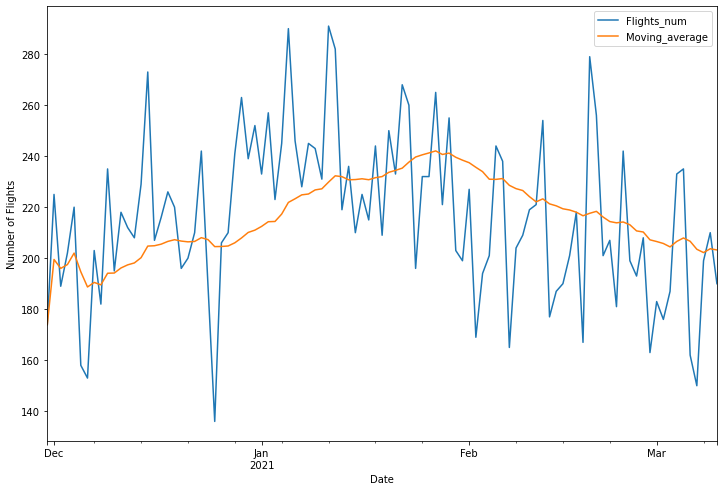

In [12]:
# Plot and show the time series
fig, ax = plt.subplots(figsize=(12,8))
fl_num.plot(ax=ax)
plt.xlabel("Date")
plt.ylabel("Number of Flights")
#plt.savefig('FW_num_flights.jpeg')
plt.show()

## Data preprocessing and validation for modeling
Split the data into a train and test set for 75/25 proportion. A splitting point at this proportion is 14Feb2021.

In [13]:
# Split the data into a train and test set
fl_num_train = fl_num.loc[:"2021-02-14"]
fl_num_test = fl_num.loc['2021-02-14':]

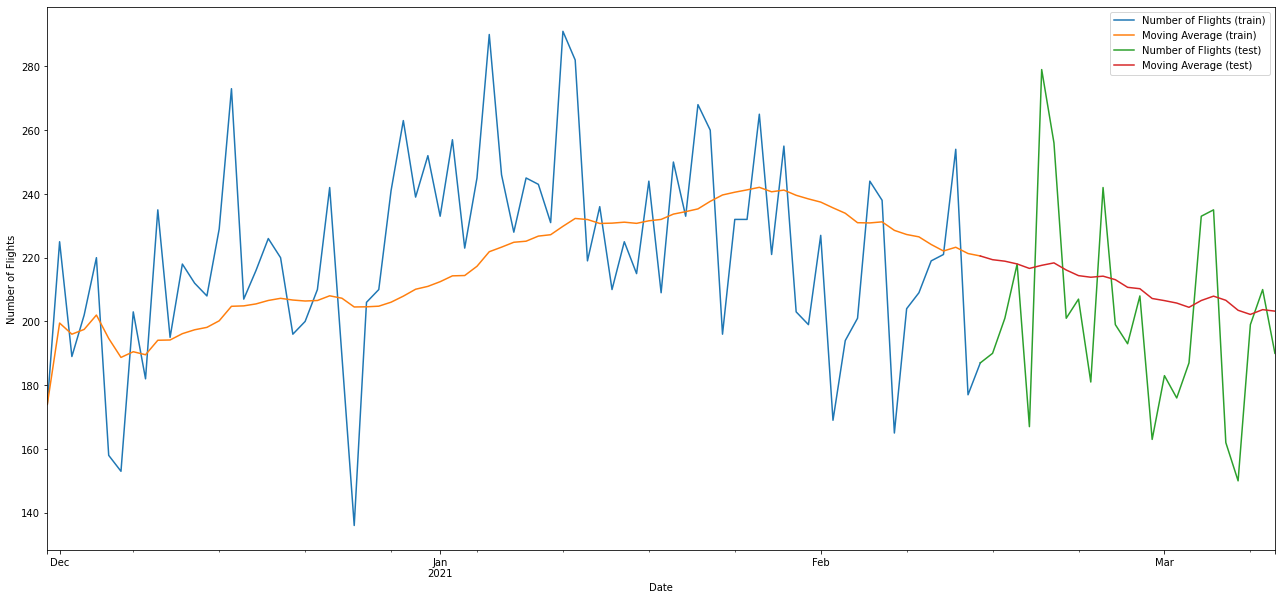

In [14]:
# Create an axis
fig, ax = plt.subplots(figsize=(22,10))

# Plot the train and test sets on the axis ax
fl_num_train.plot(ax=ax)
fl_num_test.plot(ax=ax)
plt.legend(['Number of Flights (train)', 'Moving Average (train)', 'Number of Flights (test)', 'Moving Average (test)'])
plt.xlabel("Date")
plt.ylabel("Number of Flights")
#plt.savefig('FW_num_flights_splitted.jpeg')
plt.show()

### The augmented Dicky-Fuller test
Our dataset visually looks stationary. But, we can perform non-stationarity Hypothesis Testing. The most common test for identifying whether a time series is non-stationary is the augmented Dicky-Fuller test. This is a statistical test, where the null hypothesis is that your time series is non-stationary due to the trend.

In [15]:
# Run the augmented Dicky-Fuller to test for stationarity 
result = adfuller(fl_num_train.Flights_num)

# Print test statistic
print("test statistic: ", round(result[0],2))

# Print p-value
print("p-value: ", result[1],5)

test statistic:  -6.07
p-value:  1.1308854893602047e-07 5


According to the test results, we reject a null hypothesis that our data is non-stationary. Thus, we don't require any transformations.

### Choosing the model

__What model to choose?__

How do we choose which ARIMA model to fit? AR, MA, or both? The model order is very important to the quality of forecasts. One of the main ways to identify the correct model order is by using the autocorrelation function, the ACF, and the partial autocorrelation function the PACF.

__What is the ACF__

The autocorrelation function at lag-1 is the correlation between a time series and the same time series offset by one step. The autocorrelation at lag-2 is the correlation between a time series and itself offset by two steps. And so on. When we talk about the autocorrelation function we mean the set of correlation values for different lags. We can plot the autocorrelation function to get an overview of the data. The bars show and ACF values at increasing lags. If these values are small and lie inside the blue shaded region, then they are not statistically significant.

__What is the PACF__

The partial autocorrelation is the correlation between a time series and the lagged version of itself after we subtract the effect of correlation at smaller lags. So it is the correlation associated with just that particular lag. The partial autocorrelation function is this series of values and we can plot it to get another view of the data.

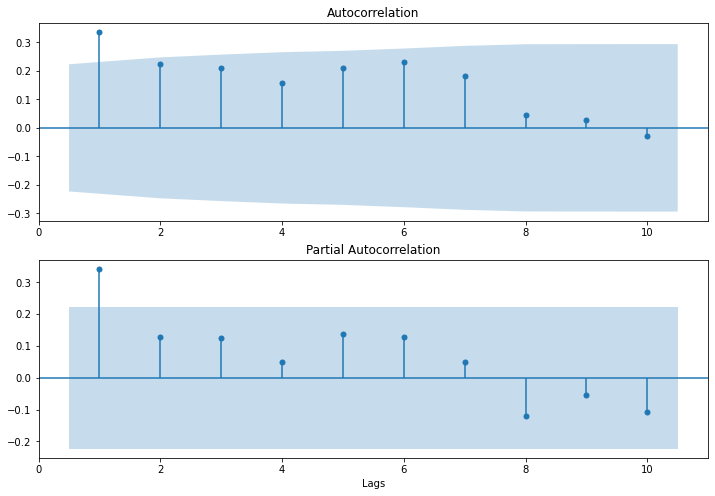

In [16]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of fl_num_train
plot_acf(fl_num_train.Flights_num, lags=10, zero=False, ax=ax1)

# Plot the PACF of fl_num_train
plot_pacf(fl_num_train.Flights_num, lags=10, zero=False, ax=ax2)

plt.xlabel("Lags")
#plt.savefig('ACF_PACF.jpeg')
plt.show()

__Plots interpretaions__

By comparing the ACF and PACF for a time series we can deduce the model order. If the amplitude of the ACF tails off with increasing lag and the PACF cuts off after some lag p, then we have an AR(p) model. If the amplitude of the ACF cuts off after some lag q and the amplitude of the PACF tails off then we have a MA(q) model. If both the ACF and PACF tail off then we have an ARMA model. In this case, we can't deduce the model orders of p and q from the plot. 

In our graph both cut off after ACF lag-1 and PACF lag-1. It identifies that it might be either AR(1), MA(1), or ARMA(1,1) model. 

What would happen if we transform our data:

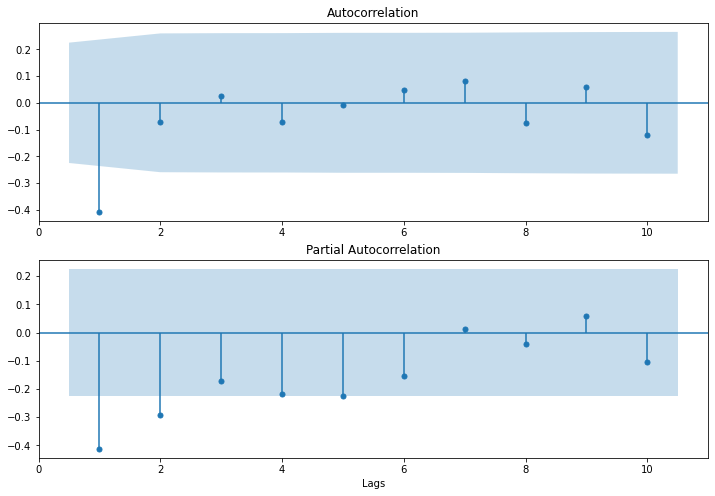

In [17]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of fl_num_train
plot_acf(fl_num_train.Flights_num.diff().dropna(), lags=10, zero=False, ax=ax1)

# Plot the PACF of fl_num_train
plot_pacf(fl_num_train.Flights_num.diff().dropna(), lags=10, zero=False, ax=ax2)

plt.xlabel("Lags")
#plt.savefig('ACF_PACF.jpeg')
plt.show()

If the autocorrelation at lag-1 is very negative this is a sign that we have taken the difference too many times.

### Model evaluation through AIC and BIC
ACF and PACF can't be used to choose the order of a model, when both of the orders p and q are non-zero. However there are more tools we can use, the AIC and the BIC. For both of these metrics, a lower value suggests a better model. The difference between these two metrics is how much they penalize model complexity. The BIC penalizes additional model orders more than AIC and so the BIC will sometimes suggest a simpler model. The AIC and BIC will often choose the same model, but when they don't we will have to make a choice. If our goal is to identify good predictive models, we should use AIC. However, if our goal is to identify a good explanatory model, we should use BIC.

In [18]:
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-2
for p in range(3):
    # Loop over q values from 0-2
    for q in range(3):
        try:
            # create and fit ARMA(p,q) model
            model = SARIMAX(fl_num_train.Flights_num, order=(p,0,q), trend='t')
            results = model.fit()
            
            # Append order and results tuple
            order_aic_bic.append((p,q, results.aic, results.bic))
            
        except:
            order_aic_bic.append((p,q, None, None))

In [19]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
order_df.sort_values('AIC').head()

,p,q,AIC,BIC
4,1,1,747.993015,757.368237
5,1,2,749.000257,760.719284
7,2,1,749.028533,760.747560
8,2,2,751.773264,765.836097
6,2,0,762.451718,771.826939


In [20]:
# Print order_df in order of increasing BIC
order_df.sort_values('BIC').head()

,p,q,AIC,BIC
4,1,1,747.993015,757.368237
5,1,2,749.000257,760.719284
7,2,1,749.028533,760.747560
8,2,2,751.773264,765.836097
6,2,0,762.451718,771.826939


Both metrics show that ARMA(1,1) is a better model. Now, when we decided which model to use, let's forecast. 

## Forecasting

In [57]:
# Create ARMA(1,1) model
arma = SARIMAX(fl_num_train.Flights_num, order=(1,0,1), trend='t', freq='D')

# Fit model
results = arma.fit()

### Model diagnostics

In [58]:
# Print fit summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:            Flights_num   No. Observations:                   77
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -369.997
Date:                Wed, 17 Mar 2021   AIC                            747.993
Time:                        18:29:15   BIC                            757.368
Sample:                    11-30-2020   HQIC                           751.743
                         - 02-14-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         -0.0035      0.019     -0.186      0.853      -0.040       0.033
ar.L1          0.9996      0.002    473.314      0.000       0.995       1.004
ma.L1         -0.7855      0.093     -8.404      0.0

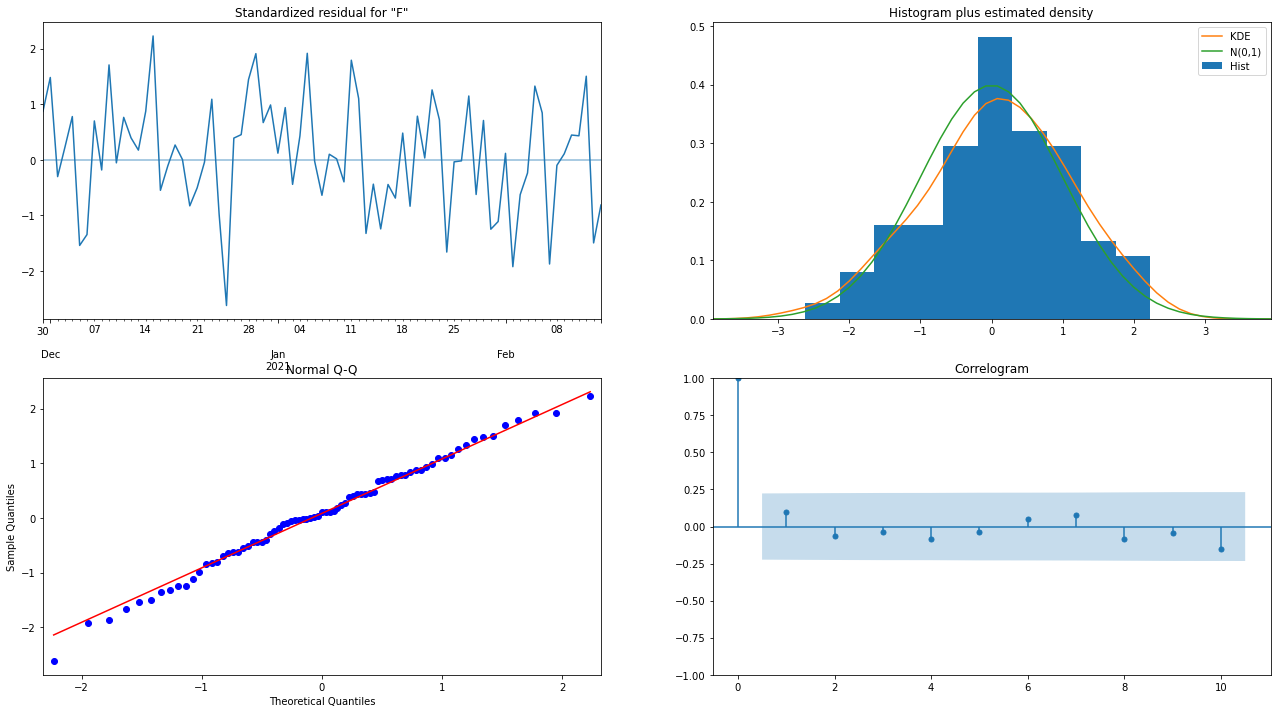

In [59]:
results.plot_diagnostics(figsize=(22,12))
plt.show()

### Forecasting in of sample
Let's test our model by making predictions in-sample train dataset. In the time period, we have data for, we can make lots of these predictions in-sample; using the previous series value to estimate the next ones. This is called a __one-step-ahead prediction__. This allows us to evaluate how good our model is at predicting just one value. Here, the mean prediction is marked with a red line while the uncertainty range is shaded (yellow). The uncertainty is due to the random shock terms that we can't predict.

We set the start parameter as a negative integer stating how many steps back to begin the forecast. Setting start to -20 means we make predictions for the last 20 entries of the training data.  

In [60]:
# Generate predictions
one_step_forecast = results.get_prediction(start = -20)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower Flights_num']
upper_limits = confidence_intervals.loc[:,'upper Flights_num']

# Print estimate  predictions
mean_forecast.head()

2021-01-26    232.503277
2021-01-27    232.091053
2021-01-28    238.828811
2021-01-29    234.697581
2021-01-30    238.728275
Freq: D, Name: predicted_mean, dtype: float64

This returns a forecast object. The central value of the forecast is stored in the <code>predicted_mean</code> attribute of the forecast object. This predicted mean is a pandas series.

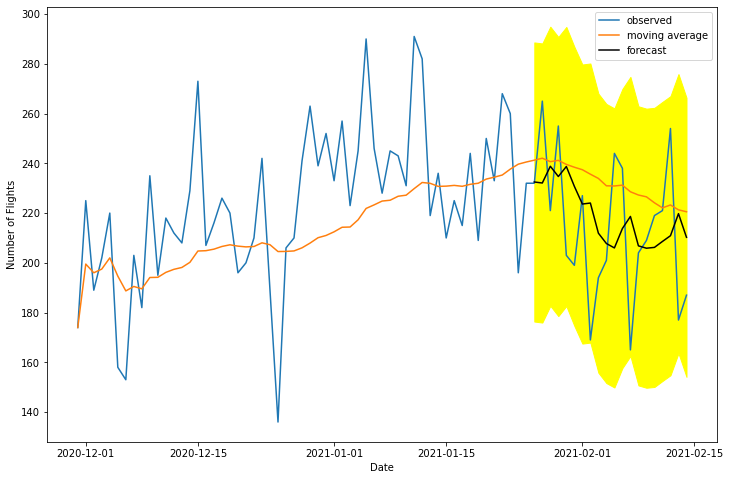

In [61]:
# plot the data
plt.figure(figsize=(12,8))
plt.plot(fl_num_train.index, fl_num_train)

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='black')

# shade the area between your confidence limits
plt.fill_between(mean_forecast.index, lower_limits,
		 upper_limits, color='yellow')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Number of Flights')
plt.legend(['observed', 'moving average', 'forecast'])
#plt.savefig('pred_in_samp.jpeg')
plt.show()

### Dynamic predictions
We can make predictions further than just one step ahead. To make these dynamic predictions we predict one step, and use this predicted value to forecast the next value after that ... and so on. Since we don't know the shock term at each step, our uncertainty can grow very quickly. Making dynamic predictions is very similar to making one-step-ahead predictions. The only difference is that in the <code>get_predictions</code> method, we set the parameter dynamic equals to true. Everything else is exactly as before.

In [62]:
# Generate predictions
dynamic_forecast = results.get_prediction(start=-20, dynamic=True)

# Extract prediction mean
mean_forecast = dynamic_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = dynamic_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower Flights_num']
upper_limits = confidence_intervals.loc[:,'upper Flights_num']

# Print estimate predictions
mean_forecast.head()

2021-01-26    232.503277
2021-01-27    232.198800
2021-01-28    231.890978
2021-01-29    231.579811
2021-01-30    231.265300
Freq: D, Name: predicted_mean, dtype: float64

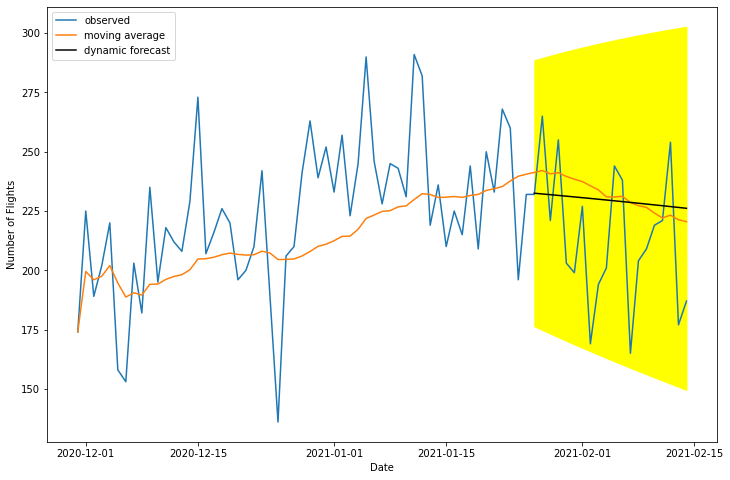

In [63]:
# plot the data
plt.figure(figsize=(12,8))
plt.plot(fl_num_train.index, fl_num_train)

# plot your mean forecast
plt.plot(mean_forecast.index, mean_forecast, color='black')

# shade the area between your confidence limits
plt.fill_between(mean_forecast.index, lower_limits, 
         upper_limits, color='yellow')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Number of Flights')
plt.legend(loc="upper left", labels=['observed', 'moving average', 'dynamic forecast'])
#plt.savefig('pred_in_samp_dyn.jpeg')
plt.show()

### Forecasting out of sample
Finally, after testing our predictions in-sample, we can use our model to predict the future. To make future forecasts we use the <code>get_forecast</code> method of the results object. We choose the number of steps after the end of the training data to forecast up to. We will forecast dynamic predictions for the next 25 days. This the date range of our test dataset. To sum up, we will plot together train, test, and predicted MA data. Then we'll compare and evaluate how accurate our model is predicted.

In [64]:
# Make ARIMA forecast of next 25 values
arima_value_forecast = results.get_forecast(steps=25).predicted_mean

# Print forecast
arima_value_forecast.head()

2021-02-15    204.917638
2021-02-16    204.555731
2021-02-17    204.190504
2021-02-18    203.821957
2021-02-19    203.450093
Freq: D, Name: predicted_mean, dtype: float64

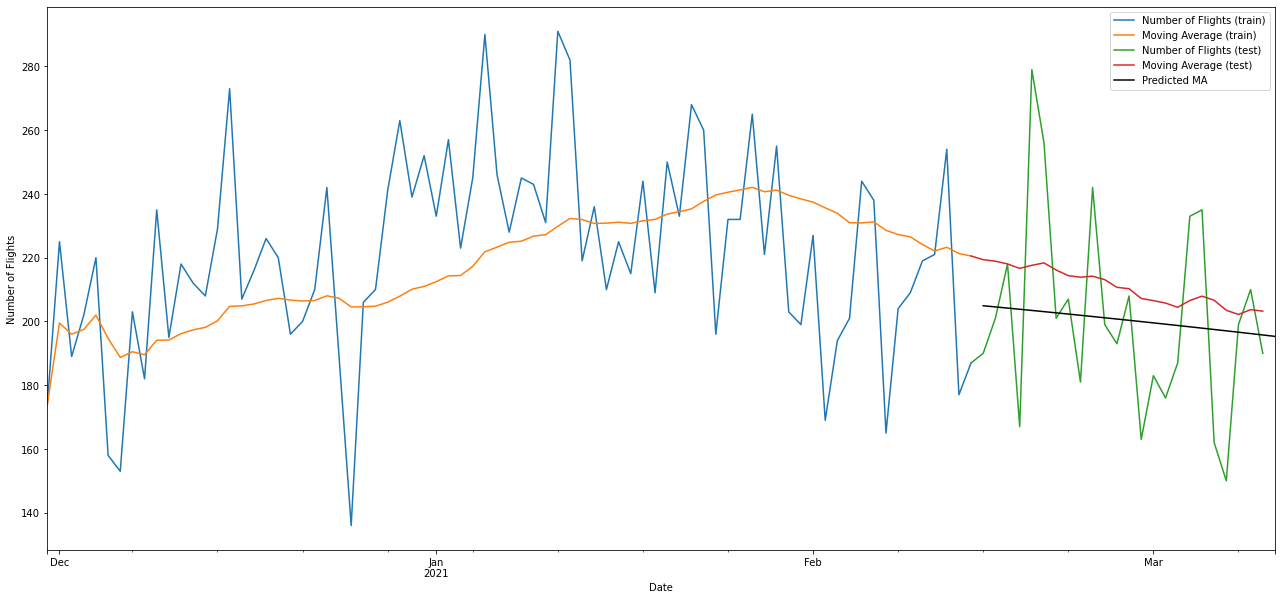

In [65]:
# Create an axis
fig, ax = plt.subplots(figsize=(22,10))

# Plot the train, test , and forecasted values on the axis ax
fl_num_train.plot(ax=ax)
fl_num_test.plot(ax=ax)
arima_value_forecast.plot(ax=ax, color='black')
plt.legend(['Number of Flights (train)', 'Moving Average (train)', 
            'Number of Flights (test)', 'Moving Average (test)', 'Predicted MA'])
plt.xlabel('Date')
plt.ylabel('Number of Flights')
#plt.savefig('pred_test.jpeg')
plt.show()

A Black line on the graph represents a predicted moving average by our model for the next 25 days. A red line is a real moving average of the test dataset. Visually, it seems that our model predicted a moving average not bad. Nevertheless, it's difficult to evaluate the accuracy of prediction by the graph.       